In [2]:
using JuMP, HiGHS
using Plots;
using VegaLite  # to make some nice plots
using DataFrames, CSV, PrettyTables
include("../src/utils.jl")
ENV["COLUMNS"]=120;

gen_df, gen_var_long, loads_long, network = process_data("../WECC")

zone_dict = Dict(zip(gen_df.zone, gen_df.zone_name));
line_dict = Dict(zip(network.network_lines, network."transmission path name"));

In [3]:
include("../src/unit_commitments.jl")

# A spring day
n=100
T_period = (n*24+6):(n*24+30)

# gen_df = gen_df[gen_df.r_id .!= 119, :]

# gen_df = gen_df[gen_df.technology .!= "Conventional Hydroelectric", :]
loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]

gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]

solution = uc_with_transport(
    gen_df, loads_multi, gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 51324 rows; 27300 cols; 153375 nonzeros; 10425 integer variables (10425 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [1e+00, 3e+04]
Presolving model
36965 rows, 26870 cols, 132488 nonzeros  0s
28077 rows, 21432 cols, 114718 nonzeros  0s
20849 rows, 19722 cols, 104541 nonzeros  0s
17632 rows, 16812 cols, 99758 nonzeros  1s
16093 rows, 15376 cols, 95231 nonzeros  2s

Solving MIP model with:
   16093 rows
   15376 cols (8838 binary, 0 integer, 0 implied int., 6538 continuous, 0 domain fixed)
   95231 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero; l => Trivial lower; u =

In [ ]:
# stop halfway through
recommit_time = 12
initial_time = n*24+6
final_time = n*24+30
T_period = (initial_time + recommit_time):(final_time)

# gen_df = gen_df[gen_df.r_id .!= 119, :]

# gen_df = gen_df[gen_df.technology .!= "Conventional Hydroelectric", :]
loads_multi = loads_long[in.(loads_long.hour,Ref(T_period)),:]

ruc_gen_var_multi = gen_var_long[in.(gen_var_long.hour, Ref(T_period)), :]

gen_vre = gen_df[gen_df[!,:vre] .== 1, :r_id]
mask = in.(ruc_gen_var_multi.r_id, Ref(gen_vre))
ruc_gen_var_multi[mask, :cf] .*= 1.5 # it's real sunny ! and windy !

ruc_solution = reliability_uc(
    solution.decision_vars, n*24+6 + recommit_time,
    gen_df, loads_multi, ruc_gen_var_multi, network, 0.01); #1% MIP Gap

Running HiGHS 1.11.0 (git hash: 364c83a51e): Copyright (c) 2025 HiGHS under MIT licence terms
MIP  has 26705 rows; 14196 cols; 74384 nonzeros; 5421 integer variables (3540 binary)
Coefficient ranges:
  Matrix [3e-01, 8e+03]
  Cost   [4e+00, 1e+06]
  Bound  [1e+00, 2e+03]
  RHS    [2e-14, 5e+04]
Presolving model
14611 rows, 10932 cols, 44372 nonzeros  0s
9697 rows, 7728 cols, 34370 nonzeros  0s
7082 rows, 7071 cols, 30369 nonzeros  0s
5659 rows, 6301 cols, 27655 nonzeros  0s
4720 rows, 5432 cols, 25874 nonzeros  0s
4325 rows, 5246 cols, 24295 nonzeros  0s

Solving MIP model with:
   4325 rows
   5246 cols (2267 binary, 0 integer, 0 implied int., 2979 continuous, 0 domain fixed)
   24295 nonzeros

Src: B => Branching; C => Central rounding; F => Feasibility pump; J => Feasibility jump;
     H => Heuristic; L => Sub-MIP; P => Empty MIP; R => Randomized rounding; Z => ZI Round;
     I => Shifting; S => Solve LP; T => Evaluate node; U => Unbounded; X => User solution;
     z => Trivial zero

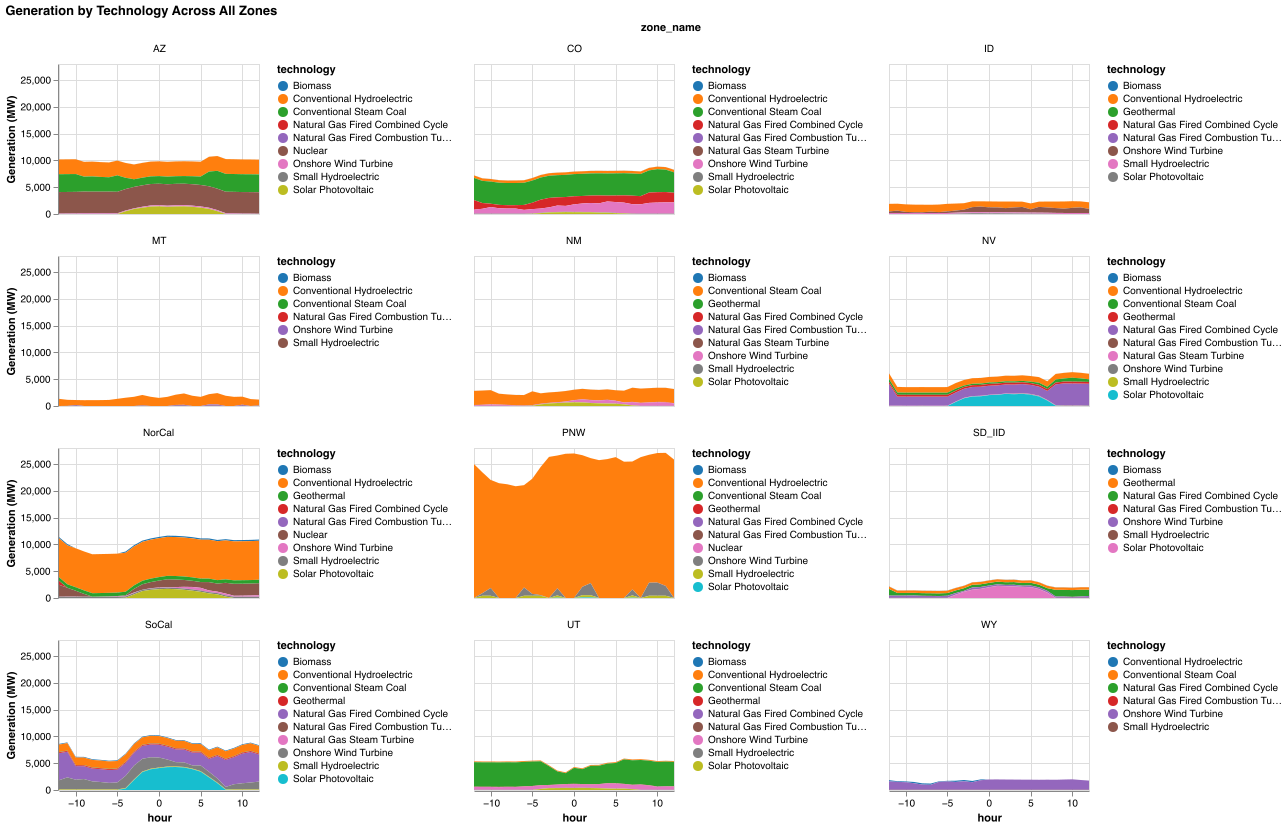

In [6]:
# Plot generation by technology for each zone in a 4x3 grid

# Join generator zone info
sol_gen_zone = innerjoin(solution.gen, gen_df[:, [:r_id, :technology, :zone]], on = :r_id)

# Group by technology, zone, and hour, then sum generation
sol_gen_zone = combine(groupby(sol_gen_zone, [:technology, :zone, :hour]), :gen => sum => :gen_sum)

# Add zone names
sol_gen_zone = innerjoin(sol_gen_zone, DataFrame(zone = collect(keys(zone_dict)), zone_name = collect(values(zone_dict))), on = :zone)

# Rescale hours
sol_gen_zone.hour = sol_gen_zone.hour .- T_period[1]

# Create the grid plot with consistent colors
sol_gen_zone |>
@vlplot(
    columns = 3,
    facet = {field = "zone_name", type = "nominal"},
    spec = {
        mark = :area,
        width = 200,
        height = 150,
        encoding = {
            x = {field = :hour, type = "quantitative"},
            y = {field = :gen_sum, type = "quantitative", stack = :zero, title = "Generation (MW)"},
            color = {field = "technology", type = "nominal", scale = {scheme = "category10"}}
        }
    },
    title = "Generation by Technology Across All Zones",
    resolve = {scale = {color = "independent"}}
)

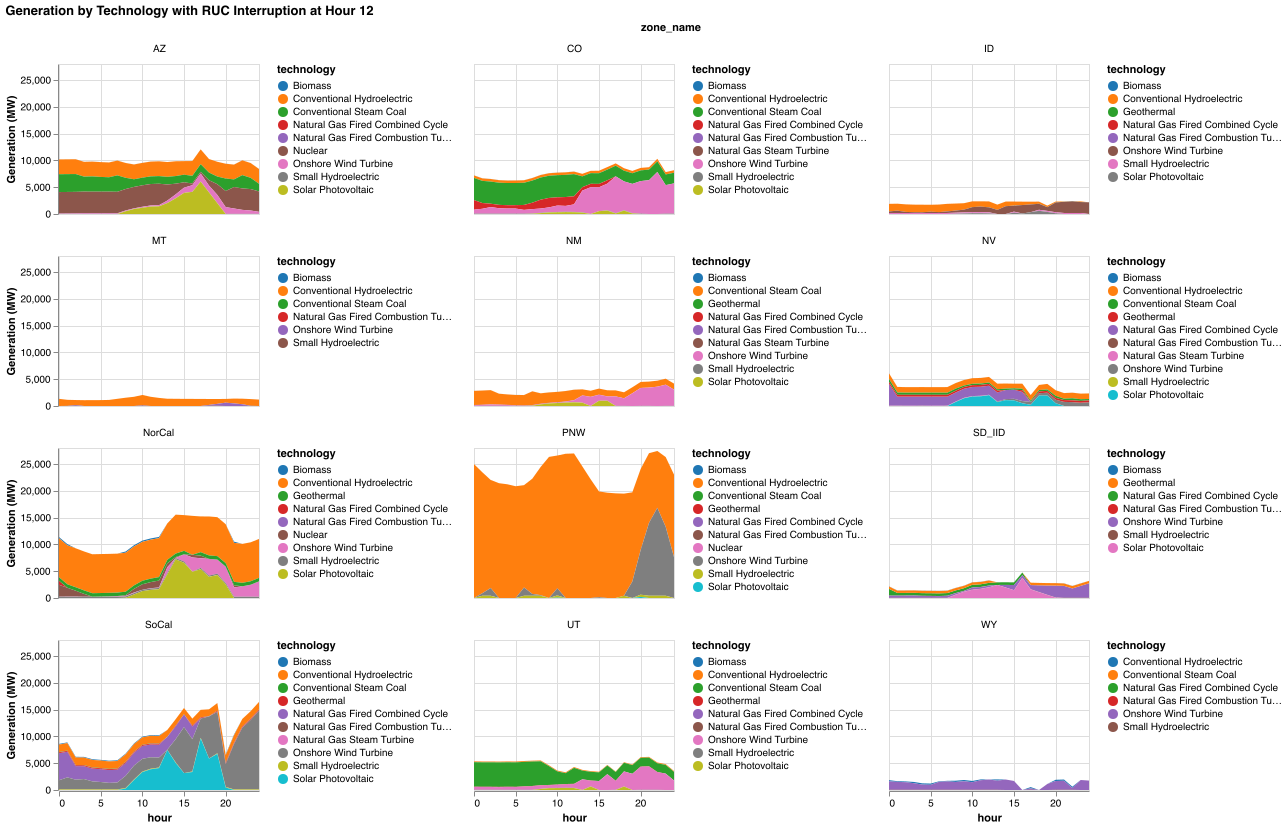

In [22]:
# Plot generation by technology for each zone in a 4x3 grid for RUC solution
# Combined with original solution for first 12 hours

# Combine original and RUC solutions by zone
combined_gen_zone = DataFrame()

# Original solution up to recommit_time (exclusive)
original_cutoff_zone = solution.gen[solution.gen.hour .< (initial_time + recommit_time), :]
original_cutoff_zone = innerjoin(original_cutoff_zone, gen_df[:, [:r_id, :technology, :zone]], on = :r_id)
original_cutoff_zone = combine(groupby(original_cutoff_zone, [:technology, :zone, :hour]), :gen => sum => :gen_sum)

# RUC solution from recommit_time onwards (inclusive)
ruc_gen_zone = innerjoin(ruc_solution.gen, gen_df[:, [:r_id, :technology, :zone]], on = :r_id)
ruc_gen_zone = combine(groupby(ruc_gen_zone, [:technology, :zone, :hour]), :gen => sum => :gen_sum)

# Combine both parts
append!(combined_gen_zone, original_cutoff_zone)
append!(combined_gen_zone, ruc_gen_zone)

# Add zone names
combined_gen_zone = innerjoin(combined_gen_zone, DataFrame(zone = collect(keys(zone_dict)), zone_name = collect(values(zone_dict))), on = :zone)

# Rescale hours
combined_gen_zone.hour = combined_gen_zone.hour .- initial_time

# Create the grid plot with consistent colors
combined_gen_zone |>
@vlplot(
    columns = 3,
    facet = {field = "zone_name", type = "nominal"},
    spec = {
        mark = :area,
        width = 200,
        height = 150,
        encoding = {
            x = {field = :hour, type = "quantitative"},
            y = {field = :gen_sum, type = "quantitative", stack = :zero, title = "Generation (MW)"},
            color = {field = "technology", type = "nominal", scale = {scheme = "category10"}}
        }
    },
    title = "Generation by Technology with RUC Interruption at Hour $(recommit_time)",
    resolve = {scale = {color = "independent"}}
)

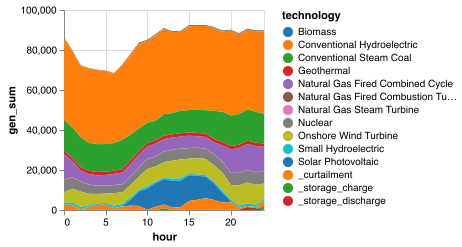

In [20]:
# Add in BTM solar and curtailment and plot results
T_period = (initial_time):(final_time)

sol_gen = innerjoin(solution.gen, 
                    gen_df[!, [:r_id, :technology]], 
                    on = :r_id)
sol_gen = combine(groupby(sol_gen, [:technology, :hour]), 
            :gen => sum)

# Curtailment
curtail = combine(groupby(solution.curtail, [:hour]),
            :curt => sum)
curtail[!, :technology] .= "_curtailment"
rename!(curtail, :curt_sum => :gen_sum)
append!(sol_gen, curtail[:,[:technology, :hour, :gen_sum]])

# Add storage discharge
for (storagetype, storagelabel, df) in [
    ("discharge", "_storage_discharge", solution.discharge_df),
    ("charge", "_storage_charge", solution.charge_df)
    ]
    storage_plot = combine(groupby(df, :hour), :value => sum)
    storage_plot[!, :technology] .= storagelabel
    rename!(storage_plot, :value_sum => :gen_sum)
    append!(sol_gen, storage_plot[:, [:technology, :hour, :gen_sum]])
end

# Rescale hours
sol_gen.hour = sol_gen.hour .- T_period[1]
# Add plot title
title = "Generation by Technology (No RUC)"
sol_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"technology:n", scale={scheme="category10"}})

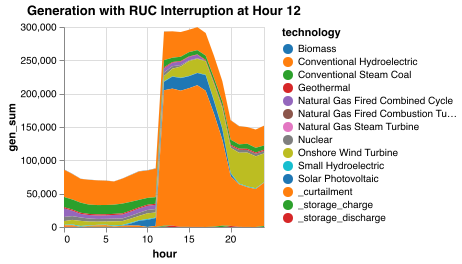

In [21]:
# Combine original and RUC solutions with interruption at recommit_time
combined_gen = DataFrame()

# Original solution up to recommit_time (exclusive)
original_cutoff = solution.gen[solution.gen.hour .< (initial_time + recommit_time), :]
original_cutoff = innerjoin(original_cutoff, gen_df[!, [:r_id, :technology]], on = :r_id)
original_cutoff = combine(groupby(original_cutoff, [:technology, :hour]), :gen => sum)

# RUC solution from recommit_time onwards (inclusive)
ruc_gen = innerjoin(ruc_solution.gen, gen_df[!, [:r_id, :technology]], on = :r_id)
ruc_gen = combine(groupby(ruc_gen, [:technology, :hour]), :gen => sum)

# Combine both parts
append!(combined_gen, original_cutoff)
append!(combined_gen, ruc_gen)

# Add curtailment from both solutions
original_curtail = solution.curtail[solution.curtail.hour .< (initial_time + recommit_time), :]
original_curtail = combine(groupby(original_curtail, [:hour]), :curt => sum)
original_curtail[!, :technology] .= "_curtailment"
rename!(original_curtail, :curt_sum => :gen_sum)

ruc_curtail = combine(groupby(ruc_solution.curtail, [:hour]), :curt => sum)
ruc_curtail[!, :technology] .= "_curtailment"
rename!(ruc_curtail, :curt_sum => :gen_sum)

append!(combined_gen, original_curtail[:,[:technology, :hour, :gen_sum]])
append!(combined_gen, ruc_curtail[:,[:technology, :hour, :gen_sum]])

# Add storage for both solutions
for (sol, time_filter) in [(solution, x -> x < (initial_time + recommit_time)), 
                          (ruc_solution, x -> true)]
    for (storagetype, storagelabel, df) in [
        ("discharge", "_storage_discharge", sol.discharge_df),
        ("charge", "_storage_charge", sol.charge_df)
        ]
        storage_data = df[time_filter.(df.hour), :]
        storage_plot = combine(groupby(storage_data, :hour), :value => sum)
        storage_plot[!, :technology] .= storagelabel
        rename!(storage_plot, :value_sum => :gen_sum)
        append!(combined_gen, storage_plot[:, [:technology, :hour, :gen_sum]])
    end
end

# Rescale hours
combined_gen.hour = combined_gen.hour .- initial_time

combined_gen |>
@vlplot(:area, 
    x=:hour, y={:gen_sum, stack=:zero}, 
    color={"technology:n", scale={scheme="category10"}},
    title="Generation with RUC Interruption at Hour $(recommit_time)")
